In [155]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# ignore all warnings as sometimes these models throw random warnings
import warnings
warnings.warn = lambda *a, **kw: False

In [49]:
df = pd.read_csv("bitcoin.csv")
df['timestamp'] = pd.to_datetime(df['timestamp']) # convert the timestamp strings into datetimes
df.head()

,timestamp,prices,market_caps,total_volumes
0,2013-04-28,135.30,1.500518e+09,0.0
1,2013-04-29,141.96,1.575032e+09,0.0
2,2013-04-30,135.30,1.501657e+09,0.0
3,2013-05-01,117.00,1.298952e+09,0.0
4,2013-05-02,103.43,1.148668e+09,0.0


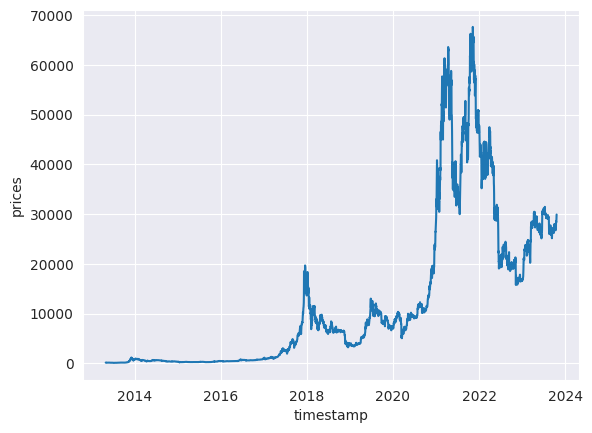

In [50]:
with sns.axes_style("darkgrid"):
    sns.lineplot(x=df['timestamp'], y=df['prices'])

/var/folders/gt/cl5hl2qx2jv0dyzpjbpbcwnr0000gn/T/ipykernel_95656/3038093656.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(returns['log_returns'])


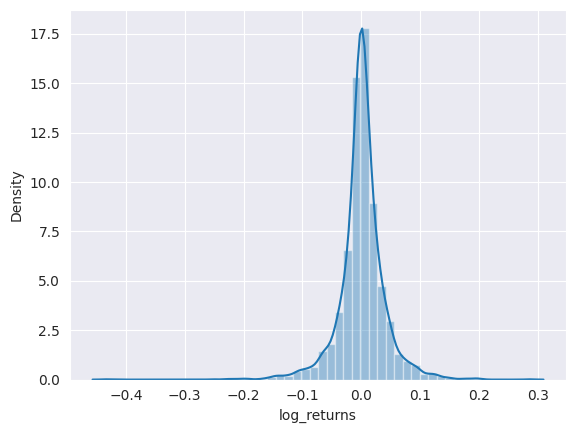

In [51]:
# 100x logged returns
df['log_returns'] = np.log(df['prices']) - np.log(df['prices']).shift(1)
df['log_returns_scaled'] = np.multiply(df['log_returns'], 100)
returns = pd.DataFrame(df['log_returns'].dropna())
with sns.axes_style("darkgrid"):
    sns.distplot(returns['log_returns'])

In [52]:
# CREATE A FUNCTION THAT CALCULATE REALIZED VOLATILITY
# FROM SAILY LOG RETURNS
def realized_volatility_daily(series_log_return):
    """
    Get the daily realized volatility which is calculated as the square root
    of sum of squares of log returns within a specific window interval 
    """
    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))

In [53]:
realized_volatility_daily(df["log_returns"])

0.039800176515436325

In [54]:
INTERVAL_WINDOW = 30
n_future = 7

# GET BACKWARD LOOKING REALIZED VOLATILITY
df['vol_current'] = df.log_returns.rolling(window=INTERVAL_WINDOW)\
                                   .apply(realized_volatility_daily)

# GET FORWARD LOOKING REALIZED VOLATILITY 
df['vol_future'] = df.log_returns.shift(-n_future)\
                                 .rolling(window=INTERVAL_WINDOW)\
                                 .apply(realized_volatility_daily)

In [55]:
df

,timestamp,prices,market_caps,total_volumes,log_returns,log_returns_scaled,vol_current,vol_future
0,2013-04-28 00:00:00,135.300000,1.500518e+09,0.000000e+00,NaN,NaN,NaN,NaN
1,2013-04-29 00:00:00,141.960000,1.575032e+09,0.000000e+00,0.048051,4.805079,NaN,NaN
2,2013-04-30 00:00:00,135.300000,1.501657e+09,0.000000e+00,-0.048051,-4.805079,NaN,NaN
3,2013-05-01 00:00:00,117.000000,1.298952e+09,0.000000e+00,-0.145321,-14.532060,NaN,NaN
4,2013-05-02 00:00:00,103.430000,1.148668e+09,0.000000e+00,-0.123279,-12.327888,NaN,NaN
...,...,...,...,...,...,...,...,...
3823,2023-10-18 00:00:00,28417.721752,5.550031e+11,1.040325e+10,-0.003358,-0.335804,0.015584,NaN
3824,2023-10-19 00:00:00,28328.245198,5.533111e+11,1.346103e+10,-0.003154,-0.315359,0.015519,NaN
3825,2023-10-20 00:00:00,28715.748142,5.593640e+11,1.119392e+10,0.013586,1.358632,0.015375,NaN
3826,2023-10-21 00:00:00,29677.392888,5.795368e+11,2.356141e+10,0.032940,3.293989,0.016532,NaN


In [56]:
df.dropna(inplace=True) # drop NaN values produced by shifts

In [57]:
df

,timestamp,prices,market_caps,total_volumes,log_returns,log_returns_scaled,vol_current,vol_future
30,2013-05-28,129.179000,1.448116e+09,0.000000e+00,0.001503,0.150292,0.067346,0.035890
31,2013-05-29,132.130000,1.481782e+09,0.000000e+00,0.022587,2.258725,0.066884,0.035813
32,2013-05-30,127.401000,1.429309e+09,0.000000e+00,-0.036447,-3.644669,0.066631,0.030177
33,2013-05-31,127.980000,1.436387e+09,0.000000e+00,0.004534,0.453441,0.060927,0.031741
34,2013-06-01,129.090000,1.449500e+09,0.000000e+00,0.008636,0.863583,0.056486,0.031865
...,...,...,...,...,...,...,...,...
3816,2023-10-11,27392.247703,5.352004e+11,1.015172e+10,-0.007330,-0.733043,0.014391,0.015584
3817,2023-10-12,26842.190439,5.236564e+11,1.460844e+10,-0.020285,-2.028512,0.013970,0.015519
3818,2023-10-13,26729.137206,5.216077e+11,1.086764e+10,-0.004221,-0.422067,0.012933,0.015375
3819,2023-10-14,26841.136221,5.236556e+11,1.434441e+10,0.004181,0.418139,0.012704,0.016532


# Train test split

In [88]:
from torch.autograd import Variable
import torch

In [89]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size

train_idx, test_idx = df.index[:train_size], df.index[train_size:]

ts_train, ts_test = df.timestamp[:train_size], df.timestamp[train_size:]
X_train, X_test, y_train, y_test = df.vol_current[:train_size], df.vol_current[train_size:], df.vol_future[:train_size], df.vol_future[train_size:]

X_train.head()

30    0.067346
31    0.066884
32    0.066631
33    0.060927
34    0.056486
Name: vol_current, dtype: float64

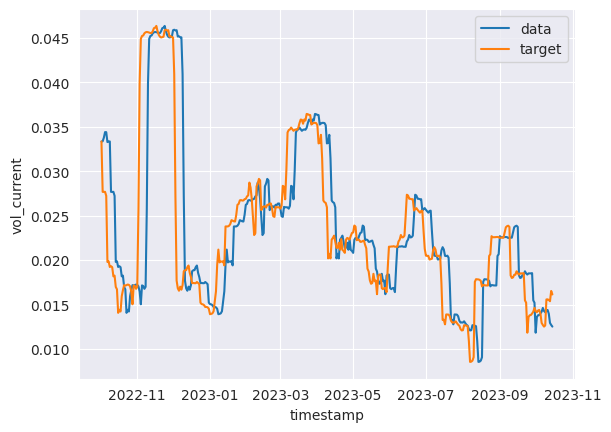

In [90]:
with sns.axes_style("darkgrid"):
    sns.lineplot(x=ts_test, y=X_test, label="data")
    sns.lineplot(x=ts_test, y=y_test, label="target")

In [147]:
forecasts = []
forecast_vals = []
for i in range(test_size):
    idx = test_idx[i]
    model = ARIMA(df.vol_current[:idx], order=(1, 1, 1))
    model_fit = model.fit()
    forecasts.append(model_fit.forecast(steps=1))
forecast_vals = [f.values[0] for f in forecasts]

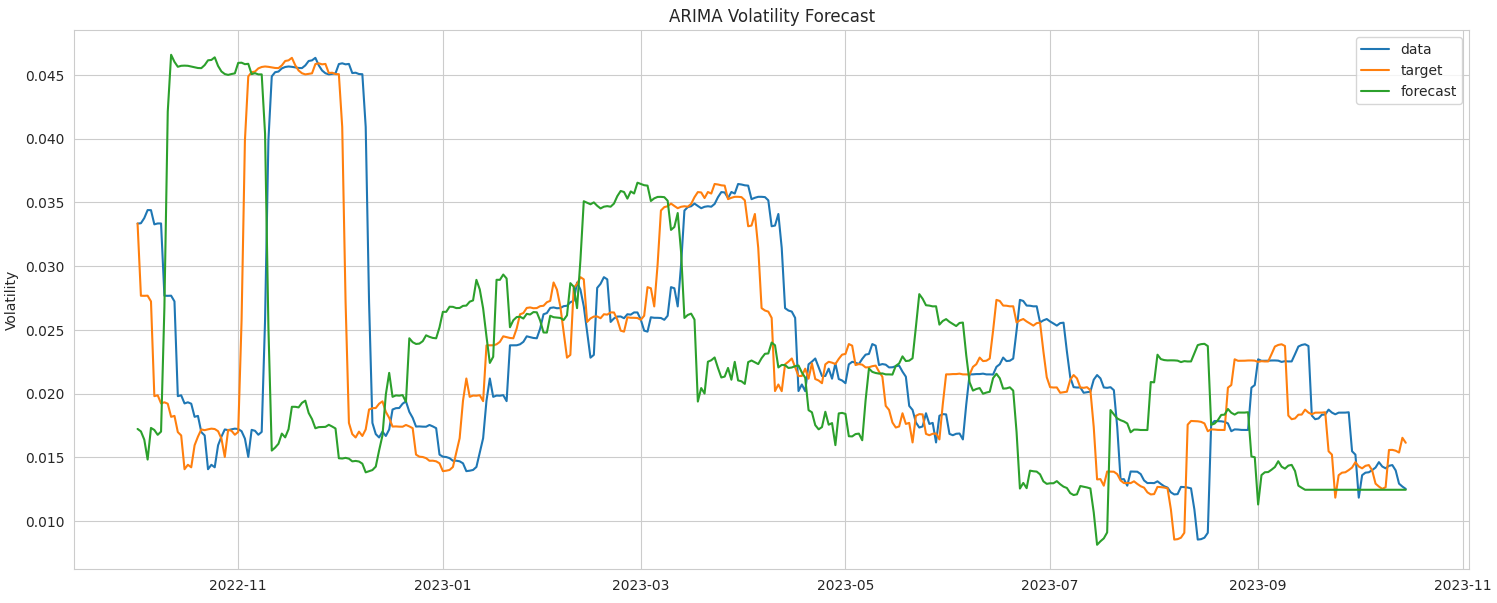

In [158]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(18,7))
    sns.lineplot(x=ts_test, y=X_test, label="data")
    sns.lineplot(x=ts_test, y=y_test, label="target")
    sns.lineplot(x=ts_test, y=forecast_vals, label="forecast")
    ax.set(xlabel='', 
           ylabel='Volatility', 
           title='ARIMA Volatility Forecast')
    plt.savefig(os.path.join("/Users/jeffhu/cs229b/proj", "ARIMA_vol.png"), dpi=300, bbox_inches='tight')